核心问题在于，判断数据集中的每个名字所属的国家，共有18个国家类别。显然，每个国家或地区的人取名字都有其自己独特的语言习惯，因此可以利用RNN分析其名字（字符串）的潜在特点来进行分类。

即序列依次经过嵌入层和RNN Cell后得到最终的隐藏状态$h_N$，利用最终的隐藏层状态通过一个线性层来进行一个18分类的多分类任务。

The num of total training epochs is 100. 
time_elapsed:[0, 16.36416530609131], Epoch 0, [2560 / 13374] loss = 0.0013631109613925219
time_elapsed:[0, 28.751747131347656], Epoch 0, [5120 / 13374] loss = 0.0005770277930423617
time_elapsed:[0, 39.39106559753418], Epoch 0, [7680 / 13374] loss = 0.00033645748044364154
time_elapsed:[0, 47.24814796447754], Epoch 0, [10240 / 13374] loss = 0.00023277479340322316
time_elapsed:[0, 56.03964400291443], Epoch 0, [12800 / 13374] loss = 0.00017854846373666078
====evaluating trained model...(is testing)
Accuracy on name-country test set is 67.164 %

time_elapsed:[1, 15.244706869125366], Epoch 1, [2560 / 13374] loss = 0.0008207075297832489
time_elapsed:[1, 26.466368436813354], Epoch 1, [5120 / 13374] loss = 0.0003788569592870772
time_elapsed:[1, 38.25314259529114], Epoch 1, [7680 / 13374] loss = 0.00022733185323886573
time_elapsed:[1, 48.243932008743286], Epoch 1, [10240 / 13374] loss = 0.0001804227358661592
time_elapsed:[1, 57.330976486206055], Epoch 1,

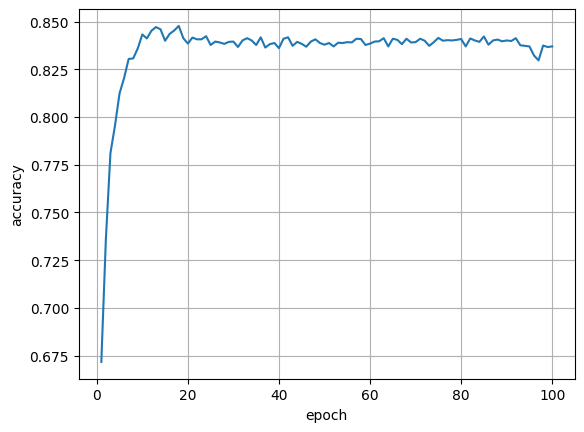

In [3]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import gzip
import csv
from torch.nn.utils.rnn import pack_padded_sequence  # 导入pack_padded_sequence()方法


'''输出共18种语言'''

'''模型主要由embedding layer, GRU和Linear layer构成'''

# parameters
NUM_CHARS = 128        # 输入字符集，用128字典长度
HIDDEN_SIZE = 100      # 隐层100维
NUM_COUNTRIES = 18
NUM_LAYERS = 2         # GRU用2层
USE_GPU = False         # GPU使用
NUM_EPOCHS = 100       # 本实验25个epoch就可以了
BATCH_SIZE = 256       # BATCH_SIZE为256


'''1.Prepare data 构建数据集类'''
class NameDataset(Dataset):
    # 初始化
    def __init__(self, is_training_set = True):
        # super(NameDataset, self).__init__()
        # 根据是否是训练集来选择文件名
        filename = "names_train.csv.gz" if is_training_set else "names_test.csv.gz"
        # 用到gzip包和csv包来从.gz文件中读取data
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader) # rows列表中每一个元素都是数据集中的一行（name+country）（元组 ）
        # 处理name
        self.name_list = [row[0] for row in rows] # 每一行的第0个元素是name
        self.len = len(self.name_list) # 记录数据集的大小（样本的总数目）
        # 处理country    
        self.orgin_country_list = [row[1] for row in rows] # 每一行的第1个元素是country，orgin_country_list中的country是有重复的，无序的
        self.country_list = list(sorted(set(self.orgin_country_list))) # set列表变集合（去除重复元素），排序，注意：country_list中的country没有重复，并且是有序的（字典序）
        self.country_dict = self.getCountryDict() # 调用函数getCountryDict()获得country_dict，字典中key:country; value:index ex: 0,1,2...
        self.num_countries = len(self.country_dict) # country的种类数，是输出维度
        
    # 根据下标获得数据集中的某一个样本信息[name+country在字典中的索引]
    def __getitem__(self, index): # （方法是以怎样的形式获取数据集）
        return self.name_list[index], self.country_dict[self.orgin_country_list[index]] # 返回name字符串和country对应的字典下标
               # 输入样本，

    # 获得数据集大小
    def __len__(self):
        return self.len
    
    # 获得country字典 （键：country, 值：字典序的下标）
    def getCountryDict(self):
        country_dict = dict() # 初始化字典
        # 将list转化为dict
        for index, country in enumerate(self.country_list, 0): # index从0开始
            country_dict[country] = index # 键：country, 值：字典序的下标
        return country_dict
    
    # 根据字典下标获得country
    def index2country(self, index):
        return self.country_dict[index]
    
    # 获得数据集中country的种类数
    def getCountriesNum(self):
        return self.num_countries
    

# 根据tensor是否迁移到GPU上 返回tensor
def createTensor(tensor):
    if USE_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device) # tensor移动到GPU上
    return tensor

'''2. Design model'''
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, bidirectional = True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        # embedding
        # input size: (seq_len, batch_size)
        # output size: (seq_len, batch_size, hidden_size)
        self.embedding = torch.nn.Embedding(input_size, hidden_size)     # 构造嵌入层
        # GRU
        # INPUTS: input size: (seq_len, batch_size, hidden_size)
        # INPUTS: hidden size: (num_layers * num_directions, batch_size, hidden_size)
        # OUTPUTS: output size: (seq_len, batch_size, hidden_size * num_directions)
        # OUTPUTS: hidden size: (num_layers * num_directions, batch_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, num_layers, bidirectional = bidirectional) # bidirectional单向还是双向
        # Linear(Fully Connected layer)
        self.fc = torch.nn.Linear(hidden_size * self.num_directions, output_size)
        
    def initHidden(self, batch_size): # 根据输入batch_size，构成一个全0的hidden张量
        hidden = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)   #（层*是否双向 batch_size hidden_size）
        return createTensor(hidden)
    
    def forward(self, input, seq_lengths):
        input = input.t() # 将input转置 batch_size * seq_len --> seq_len * batch_size
        batch_size = input.size(1)

        hidden = self.initHidden(batch_size) # init hidden 0
        
        # embedding layer
        embedding = self.embedding(input) # embedding size: batch_size, seq_len, embedding_size
        
        # GRU
        gru_input = pack_padded_sequence(embedding, seq_lengths) # pack_padded_sequence，将输入转化为size为seq_len, batch_size, hidden_size的tensor
            # 返回一个PackedSequence对象        
            # 第2个参数：一个tensor， 是每个batch element的长度列表
        output, hidden = self.gru(gru_input, hidden)
        if self.num_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim = 1) # GRU为双向时，hidden = [前向的第n个hidden, 反向的第n个hidden] 连接
        else:
            hidden_cat = hidden[-1] # GRU为单向时，hidden = 前向的第n个hidden
            
        # fully connected layer
        fc_output = self.fc(hidden_cat)
        return fc_output

## convert name to tensor
# 必须sort the batch element by length of sequence(降序)
# name -> characters -> ASCII值 -> padding -> （transpose） ->sort
    
# 将某个name转换为相应的字符对应的ASCII码值的列表  "Alice" -> ['A','l','i','c','e'] -> [65 108 105 99 101]
def name2ASCIIlist(name):
    ASCIIlist = [ord(char) for char in name] # ord(char)获取char的ASCII码值
    return ASCIIlist
    
def makeTensors(name_list, country_list):
    ## 获得每个name的码值列表，然后得到所有码值列表的列表 
    name_sequences = [name2ASCIIlist(name) for name in name_list] # name -> characters_list -> ASCII值_list
    name_seq_lens = [len(name_ASCII) for name_ASCII in name_sequences] # 每个姓名ASCII序列的长度的列表
    # 数值类型转换
    name_seq_lens = torch.LongTensor(name_seq_lens)
    country_list = country_list.long()
    
    ## padding   make tensor of name, BatchSize * SeqLen 
    # 先构造一个（dataset.len, max(name_seq_len)）大小的全0张量
    name_tensor = torch.zeros(len(name_sequences), name_seq_lens.max()).long()
    # 然后将每个name_sequence填到全0张量中
    for index, (name_sequence, name_seq_len) in enumerate(zip(name_sequences, name_seq_lens), 0):
        name_tensor[index, 0:name_seq_len] = torch.LongTensor(name_sequence) # 第index行的第0列到第len(name_seq)列 填入 name_sequence
    
    ## sort by length of name_sequence to use pack_padded_sequence
    ordered_name_seq_lens, len_indexes = name_seq_lens.sort(dim = 0, descending = True) # 首先将name_seq_lens降序排序，len_indexes是它在原tensor中的索引
    ordered_name_tensor = name_tensor[len_indexes] # 按照新的下标更新name_tensor
    ordered_country_list = country_list[len_indexes] # 同步更新country_list中的值
    
    ## 返回转化后的name tensor, name's length tensor and country_list tensor
    return createTensor(ordered_name_tensor), createTensor(ordered_name_seq_lens), createTensor(ordered_country_list) 
    
    
'''3. Training and Test'''
def train():  # 每个epoch的训练过程
    loss = 0.0
    for batch_index, (names, countries) in enumerate(train_loader, 0): # 每一次取出一个batch中的所有样本
        ## 对于每一个batch中的所有样本，做如下操作：
        # forward
        inputs, seq_lens, targets = makeTensors(names, countries) 
        outputs = classifier_model(inputs, seq_lens)
        loss = criterion(outputs, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # update
        optimizer.step()
        
        loss += loss.item()
        
        if batch_index % 10 == 9: # 每10个batch输出一次信息
            print(f'time_elapsed:{timePassed(start_time)}, Epoch {epoch}, ', end = '') # 输出经过的时间和epoch
            print(f'[{(batch_index+1) * len(inputs)} / {len(training_set)}] ', end = '') # 已经训练过的样本数/总样本数，用来表示训练进度
            print(f'loss = {loss / ((batch_index+1) * len(inputs))}') # loss求均值

def test():
    correct = 0
    total_samples = len(test_set)
    print("====evaluating trained model...(is testing)")
    with torch.no_grad():
        for i, (names, countries) in enumerate(test_loader, 0):
            inputs, seq_lens, targets = makeTensors(names, countries)
            outputs = classifier_model(inputs, seq_lens)
            #country_pred = torch.max(output, dim = 1)
            country_preds = outputs.max(dim = 1, keepdim = True)[1]
            #correct += (country_pred == target).sum().item()
            correct += country_preds.eq(targets.view_as(country_preds)).sum().item()
        accuracy = correct / total_samples
        print('Accuracy on name-country test set is %.3f %%\n' % (100 * accuracy)) # 化为百分数
    return accuracy
        

## 计算经过的时间
def timePassed(start_time): # 参数：开始时间
    time_passed = time.time() - start_time # 经过的时间，返回以秒为单位
    # 换算为分和秒
    minute = math.floor(time_passed / 60) # 取下整
    second = time_passed - minute * 60    # 剩多少秒 
    return [minute, second] # 返回值：几分几秒


'''4. Main cycle'''
if __name__ == '__main__':
    # 数据准备
    training_set = NameDataset(is_training_set = True)
    train_loader = DataLoader(dataset = training_set, batch_size = BATCH_SIZE, shuffle = True)
    test_set = NameDataset(is_training_set = False)
    test_loader = DataLoader(dataset = test_set, batch_size = BATCH_SIZE, shuffle = False)
        
    NUM_COUNTRIES = training_set.getCountriesNum()  # 给NUM_COUNTRIES赋值   总的类别数量
    
    # 定义模型对象
    classifier_model = RNNClassifier(NUM_CHARS, HIDDEN_SIZE, NUM_COUNTRIES, NUM_LAYERS) # input_size, hidden_size, output_size, num_layers  创建分类器
    if USE_GPU: # 是否用GPU训练模型
        device = torch.device("cuda:0") # 申请GPU cuda:0
        classifier_model.to(device)     # 将模型迁移到GPU上
    
    # 构建loss function和optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier_model.parameters(), lr = 0.001)
    
    # training and test
    start_time = time.time() # 开始时间
    print("The num of total training epochs is %d. " % NUM_EPOCHS)
    accuracy_list = []
    for epoch in range(NUM_EPOCHS):
        train()
        accuracy = test()
        accuracy_list.append(accuracy)
    

    # 作图 epoch-accuracy
    epoch_list = np.arange(1, NUM_EPOCHS + 1, 1) # epoch从1到NUM_EPOCHS
    accuracy_list = np.array(accuracy_list)
    plt.plot(epoch_list, accuracy_list)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.show()
